In [16]:
import argparse
import torch
parser = argparse.ArgumentParser()
    # dataset part
parser.add_argument('--data_dir', type=str, default='Food-Kitchen', help='Movie-Book, Entertainment-Education')

# model part
parser.add_argument('--model', type=str, default="C2DSR", help='model name')
parser.add_argument('--hidden_units', type=int, default=128, help='lantent dim.')
parser.add_argument('--num_blocks', type=int, default=2, help='lantent dim.')
parser.add_argument('--num_heads', type=int, default=1, help='lantent dim.')
parser.add_argument('--GNN', type=int, default=1, help='GNN depth.')
parser.add_argument('--dropout', type=float, default=0.2, help='dropout rate.')
parser.add_argument('--optim', choices=['sgd', 'adagrad', 'adam', 'adamax'], default='adam', help='Optimizer: sgd, adagrad, adam or adamax.')
parser.add_argument('--param_group', type = bool, default=False, help='param group')
parser.add_argument('--lr', type=float, default=0.001, help='Applies to sgd and adagrad.')
parser.add_argument('--lr_decay', type=float, default=1, help='Learning rate decay rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters).')
parser.add_argument('--decay_epoch', type=int, default=5, help='Decay learning rate after this epoch.')
parser.add_argument('--max_grad_norm', type=float, default=5.0, help='Gradient clipping.')
parser.add_argument('--leakey', type=float, default=0.1)
parser.add_argument('--maxlen', type=int, default=50)
parser.add_argument('--cpu', action='store_true', help='Ignore CUDA.')
parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available(), help='Enables CUDA training.')
parser.add_argument('--lambda', type=float, default=0.7)

# train part
parser.add_argument('--num_epoch', type=int, default=100, help='Number of total training epochs.')
parser.add_argument('--batch_size', type=int, default=256, help='Training batch size.')
parser.add_argument('--log_step', type=int, default=200, help='Print log every k steps.')
parser.add_argument('--log', type=str, default='log.txt', help='Write training log to file.')
parser.add_argument('--save_epoch', type=int, default=100, help='Save model checkpoints every k epochs.')
parser.add_argument('--save_dir', type=str, default='./saved_models', help='Root dir for saving models.')
parser.add_argument('--id', type=str, default=00, help='Model ID under which to save models.')
parser.add_argument('--seed', type=int, default=2023)
parser.add_argument('--load', dest='load', action='store_true', default=False,  help='Load pretrained model.')
parser.add_argument('--model_file', type=str, help='Filename of the pretrained model.')
parser.add_argument('--info', type=str, default='', help='Optional info for the experiment.')
parser.add_argument('--undebug', action='store_false', default=True)

# data augmentation
parser.add_argument('--augment_type', type=str, default="crop", help='augment type')
parser.add_argument('--crop_prob', type=float, default=0.8, help='crop probability')
parser.add_argument('--mask_prob', type=float, default=0.2, help='mask probability')
# time ssl
parser.add_argument('--window_size',type=int,default=3 ,help="window size for ssl")
parser.add_argument('--temp',type=float,default=0.05 ,help="temperature for ssl")
parser.add_argument('--ssl',type=str ,default="augmentation_based_CL" ,help="[time_CL, augmentation_based_CL, no_ssl, proto_CL]")
#early stop
parser.add_argument('--patience',type=int,default=5 ,help="early stop counter")

parser.add_argument('--pooling',type=str,default="ave" ,help="pooling method")
parser.add_argument('--is_pooling',type=bool,default=True ,help="pooling or not")

#MoCo
parser.add_argument('--r',type=int,default=1280 ,help="queue size/negative sample") #warning : r must be divisible by batch_size
parser.add_argument('--m',type=float,default=0.999 ,help="momentum update ratio for moco")
parser.add_argument('--num_cluster', type=str, default= '3000,5000,7000' ,help="number of clusters for kmeans")
parser.add_argument('--warmup_epoch', type=int, default= 1 ,help="warmup epoch for cluster")
parser.add_argument("--mlp", type=bool, default=True, help="use projector or not")
# args = parser.parse_args()

parser.add_argument('--cross_weight',type=float,default=0.001 ,help="cross domain weight for proto CL")
parser.add_argument('--num_proto_neg',type=int,default= 1280 ,help="intra domain weight for proto CL")
#pretrain
parser.add_argument('--pretrain',default= False, action='store_true', help="pretrain or not")
parser.add_argument('--pretrain_model',type=str,default= None ,help="pretrain or not")
parser.add_argument('--joint_learn',default= False , action='store_true', help="pretrain epoch")
# parser.add_argument('--',type=bool,default=True ,help="use MoCo or not")
# args = parser.parse_args()
args, unknown = parser.parse_known_args()
# main(args)

In [17]:
import glob
import numpy as np
import torch
from pathlib import Path
# mode = ["no_time_ssl","time_ssl_w3","time_ssl_w5","time_ssl_w7","time_ssl_w10","time_ssl_w14"]
# mode = ["domain_proto_CL_pooler_crop_0.7","domain_proto_CL_pooler_crop_0.6","in-domain_proto_CL_pooler_crop_0.5","in-domain_proto_CL_pooler","in-domain_proto_CL","no_ssl"]
# mode = ["no_ssl","augmentation_based_CL_poolingave","augmentation_based_CL_dropout","augmentation_based_CL_poolingave_mixed_dropout"]
# mode = ["in-domain_proto_CL_pooler_crop_0.5","domain_proto_CL_pooler_crop_0.6","domain_proto_CL_pooler_crop_0.7","in-domain_proto_CL_pooler"]
# mode = ["proto_CL_only_cluster","proto_only_augmentation_based_CL_dropout","no_ssl_no_graph"]
# mode = ["augmentation_CL_dropout","augmentation_CL_crop","no_ssl_no_graph"]
# mode = ["proto_CL_only_aug_mixed_crop","proto_only_augmentation_based_CL_crop", "proto_CL_only_aug_mixed_dropout","proto_only_augmentation_based_CL_dropout","no_ssl_no_graph"]
# mode = ["proto_CL_only_aug_dropout_t0.01","proto_CL_only_aug_dropout_t0.1","proto_CL_only_aug_dropout_t0.5","no_ssl_no_graph"]
# mode = ['proto_only_augmentation_based_CL_dropout','proto_CL_only_aug_dropout_t0.1', "proto_CL_only_aug_dropout_t0.01", "proto_CL_only_aug_dropout_t0.5","no_ssl_no_graph"]
# mode = ["proto_CL_only_cluster_5_15s","proto_CL_only_cluster_100_300","proto_CL_only_cluster_500_1000","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_cluster_5_15_epoch10", "finetune_proto_CL_dropout_cluster_5_15_epoch40","finetune_proto_CL_dropout_cluster_5_15_epoch70","no_ssl_no_graph"]
# mode = ["no_ssl_no_graph","no_ssl_no_graph_time_encode"]
# mode = ["finetune_proto_CL_dropout_cluster_500_1000_epoch10", "finetune_proto_CL_dropout_cluster_500_1000_epoch40","finetune_proto_CL_dropout_cluster_500_1000_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_joint_cluster_1000_2000_epoch10", "finetune_proto_CL_dropout_joint_cluster_1000_2000_epoch40","finetune_proto_CL_dropout_joint_cluster_1000_2000_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_joint_cluster_500_1000_epoch10", "finetune_proto_CL_dropout_joint_cluster_500_1000_epoch40","finetune_proto_CL_dropout_joint_cluster_500_1000_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_joint_cluster_100_300_epoch10", "finetune_proto_CL_dropout_joint_cluster_100_300_epoch40","finetune_proto_CL_dropout_joint_cluster_100_300_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_cluster_600_800_epoch10", "finetune_proto_CL_dropout_cluster_600_800_epoch40","finetune_proto_CL_dropout_cluster_600_800_epoch70","no_ssl_no_graph"]
mode = ["finetune_proto_CL_dropout_joint_cluster_5_15_epoch40","finetune_proto_CL_dropout_joint_cluster_100_300_epoch40","finetune_proto_CL_dropout_joint_cluster_500_1000_epoch40","finetune_proto_CL_dropout_cluster_joint_400_600_epoch40",
        "finetune_proto_CL_dropout_cluster_600_800_epoch40","finetune_proto_CL_dropout_cluster_800_1200_epoch40","finetune_proto_CL_dropout_joint_cluster_1000_2000_epoch40","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_cluster_800_1200_epoch10", "finetune_proto_CL_dropout_cluster_800_1200_epoch40","finetune_proto_CL_dropout_cluster_800_1200_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_epoch40", "finetune_proto_CL_crop_epoch40","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_joint_epoch10", "finetune_proto_CL_dropout_joint_epoch40","finetune_proto_CL_dropout_joint_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_cluster_joint_100_300_mixed_epoch10", "finetune_proto_CL_dropout_cluster_joint_100_300_mixed_epoch20","finetune_proto_CL_dropout_cluster_joint_100_300_mixed_epoch40","finetune_proto_CL_dropout_cluster_joint_100_300_mixed_epoch70","no_ssl_no_graph"]
# mode = ["finetune_proto_CL_dropout_cluster_joint_500_1000_mixed_epoch10", "finetune_proto_CL_dropout_cluster_joint_500_1000_mixed_epoch20","finetune_proto_CL_dropout_cluster_joint_500_1000_mixed_epoch40","finetune_proto_CL_dropout_cluster_joint_500_1000_mixed_epoch70","no_ssl_no_graph"]
mode = ["finetune_time_ssl_time_equivariance_joint_pretrain_epoch10","finetune_time_ssl_time_equivariance_joint_pretrain_epoch20","finetune_time_ssl_time_equivariance_joint_pretrain_epoch30","finetune_time_ssl_time_equivariance_joint_pretrain_epoch40","finetune_time_ssl_time_equivariance_joint_pretrain_epoch30","finetune_time_ssl_time_equivariance_joint_pretrain_epoch40","no_ssl_no_graph"]
mode = ["joint_learn_NNCL","joint_learn_NNCL_10","joint_learn_triple_pull","no_ssl_no_graph"]
# mode = ["finetune_time_ssl_joint_pretrain_epoch10","finetune_time_ssl_joint_pretrain_epoch20","finetune_time_ssl_time_equivariance_joint_pretrain_epoch30","finetune_time_ssl_joint_pretrain_epoch40","finetune_time_ssl_joint_pretrain_epoch30","finetune_time_ssl_joint_pretrain_epoch40","no_ssl_no_graph"]
# mode = ["finetune_time_equivariance_joint_pretrain_causality_epoch10","finetune_time_equivariance_joint_pretrain_causality_epoch20","finetune_time_equivariance_joint_pretrain_causality_epoch30","finetune_time_equivariance_joint_pretrain_causality_epoch40","no_ssl_no_graph"]
# mode = ["finetune_time_ssl_joint_pretrain_causality_epoch10","finetune_time_ssl_joint_pretrain_causality_epoch20","finetune_time_ssl_joint_pretrain_causality_epoch30","finetune_time_ssl_joint_pretrain_causality_epoch40","no_ssl_no_graph"]
# mode = ["finetune_time_equivariance_joint_pretrain_causality_epoch10","finetune_time_equivariance_joint_pretrain_causality_epoch20","finetune_time_equivariance_joint_pretrain_causality_epoch30","finetune_time_equivariance_joint_pretrain_causality_epoch40","no_ssl_no_graph"]
# mode = ["finetune_time_ssl_attention_joint_pretrain_epoch10","finetune_time_ssl_attention_joint_pretrain_epoch20","finetune_time_ssl_attention_joint_pretrain_epoch30","finetune_time_ssl_attention_joint_pretrain_epoch40","no_ssl_no_graph_with_time_attention","no_ssl_no_graph"]
mode =["finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_included_epoch10","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_pred_epoch10","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_included_epoch20","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_pred_epoch20","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_included_epoch40","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_pred_epoch40","no_ssl_no_graph"]
# mode =["finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_pred_epoch10","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_pred_epoch20","finetune_proto_CL_dropout_cluster600_800_joint_pretrain_mixed_pred_epoch40","no_ssl_no_graph"]
# mode =["fairness_baseline","fairness_female_Y","fairness_male_Y"]
mode =["test"]
# data_names = ["action_thriller","action_romance"]
# data_names = ["action_animation","action_comedy"]
data_names = ["action_thriller","action_romance","action_animation","action_comedy"]
# data_names = ["Food-Kitchen","Movie-Book"]
target_num_file = 10.0
for data_name in data_names:
    print("-"*50)
    print("Data:",data_name)
    for m in mode:
        f_list = glob.glob(f"./saved_models/{data_name}/{m}/*")
        f_list = sorted(f_list,key = lambda x: int(x.split("/")[-1]))
        avg_X_res = {
                    "test_X_MRR":0,
                    "test_X_NDCG_10":0,
                    "test_X_HR_10":0
                }
        avg_Y_res = {
            "test_Y_MRR":0,
            "test_Y_NDCG_10":0,
            "test_Y_HR_10":0
        }
        print(" ")
        num_f = min(target_num_file,len(f_list))
        for i, f in enumerate(f_list):
            if i >= target_num_file:
                continue
            with open(f+"/log.txt", "r") as f:
                data = f.readlines()[-3:-1]
                print(data)
                try:
                    best_x = eval(data[0])['Best X domain']
                    best_y = eval(data[1])['Best Y domain']
                    for j,(k,v) in enumerate(avg_X_res.items()):
                        avg_X_res[k] += best_x[j]
                        
                    for j,(k,v) in enumerate(avg_Y_res.items()):
                        avg_Y_res[k] += best_y[j]
                except:
                    print("error:",f)
                    num_f-=1
        print("Number of file:",int(num_f))
        if num_f == 0:
            continue
        X_res = {key: round(value / (num_f), 4) for key, value in avg_X_res.items()}
        Y_res = {key: round(value / (num_f), 4) for key, value in avg_Y_res.items()}
        folder_path=f"./result/{data_name}"
        Path(folder_path).mkdir(parents=True, exist_ok=True)    
        with open(f"./result/{m}.txt","w") as f: 
            f.write("X domain testing result (avg over 5 seed):"+str(X_res)+"\n")
            f.write("Y domain testing result (avg over 5 seed):"+str(Y_res)+"\n")
        print("Mode:",m)
        print(X_res)
        print(Y_res)
    print("-"*50)

--------------------------------------------------
Data: action_thriller
 
Number of file: 0
--------------------------------------------------
--------------------------------------------------
Data: action_romance
 
Number of file: 0
--------------------------------------------------
--------------------------------------------------
Data: action_animation
 
Number of file: 0
--------------------------------------------------
--------------------------------------------------
Data: action_comedy
 
Number of file: 0
--------------------------------------------------


In [5]:
import glob
import numpy as np
import torch
from pathlib import Path
# mode =[ "fairness_Y_generator_20epoch_eval","fairness_Y_generator_40epoch_eval","fairness_Y_generator_60epoch_eval"]
mode_name = glob.glob("./saved_models/comedy_drama/fairness_maintaskY_interest*_eval")
# mode = ["fairness_baseline_Y_eval"]+[x.split("/")[-1] for x in mode_name if "mixed" not in x] 
mode = ["fairness_baseline_Y_eval"]+[x.split("/")[-1] for x in mode_name if "mixed" in x]
# mode = ["fairness_maintaskY_generatorX_generatenum3_20epoch_eval","fairness_maintaskY_generatorX_generatenum5_20epoch_eval","fairness_maintaskY_generatorX_generatenum7_20epoch_eval",
#         "fairness_maintaskY_generatorY_generatenum3_20epoch_eval","fairness_maintaskY_generatorY_generatenum5_20epoch_eval","fairness_maintaskY_generatorY_generatenum7_20epoch_eval",
#         "fairness_maintaskY_generatormixed_generatenum3_20epoch_eval","fairness_maintaskY_generatormixed_generatenum5_20epoch_eval","fairness_maintaskY_generatormixed_generatenum7_20epoch_eval"
        # ]
# mode = ["fairness_maintaskY_generatorY_generatenum3_20epoch_eval","fairness_maintaskY_generatorY_generatenum5_20epoch_eval"]
# mode = ["fairness_maintaskY_generatormixed_generatenum3_20epoch_eval","fairness_maintaskY_generatormixed_generatenum5_20epoch_eval"]

# mode = ["fairness_baseline_Y_single_domain_eval","fairness_baseline_Y_eval"]
# mode = ["fairness_baseline_Y_single_domain_eval","fairness_baseline_Y_eval","fairness_baseline_X_single_domain_eval","fairness_baseline_X_eval"]
# mode = ["fairness_baseline_Y_eval","fairness_maintaskY_generatorAll_generatenumPoisson_random_20epoch_eval","fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_eval"]
# mode = ["fairness_baseline_Y_eval",'fairness_maintaskY_generatorAll_generatenumPoisson_random_20epoch_eval',"fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_eval","fairness_maintaskY_usergen_sequentialSim_repeat2_eval"]
# mode = ["fairness_baseline_Y_eval","fairness_maintaskY_generatorAll_generatenumPoisson_random_20epoch_eval","fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_unbalance_eval","fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_eval"]
# mode = ["fairness_baseline_Y_eval","fairness_baseline_Y_single_domain_eval"]
# mode = ["fairness_baseline_Y_eval","fairness_maintaskY_usergen_same_repeat2_eval","fairness_maintaskY_usergen_random_repeat2_eval","fairness_maintaskY_usergen_sequentialSim_repeat2_eval","fairness_maintaskY_usergen_sequentialSimTop5_repeat2_eval"]
# mode = ["fairness_baseline_Y_eval","fairness_maintaskY_usergen_biasFree_eval","fairness_maintaskY_usergen_biasFree_fakelabel_eval"]
# mode = ["fairness_baseline_Y_eval","fairness_maintaskY_generatorAll_generatenumPoisson_random_20epoch_eval","fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_eval","fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_unbalance_max7_eval"]
# mode = ['fairness_baseline_Y_eval',"fairness_maintaskY_usergen_biasFree_fakelabel_eval", "fairness_maintaskY_usergen_biasFree_lambda2_eval","fairness_maintaskY_none_biasFree_eval"]
# mode= ["fairness_baseline_Y_eval","fairness_maintaskY_generatorAll_generatenumPoisson_20epoch_eval","fairness_maintaskY_generatorAll_generatenumPoisson_sample10_IFTop5_20epoch_eval"]
folder_list = glob.glob("./fairness_dataset/Movie_lens_time/*")
folder_list = [x.split("/")[-1] for x in folder_list]
data_names = [x for x in folder_list if x not in ["item_statistic.ipynb","data_preprocess.py","raw_data"]]

domains = ["Y","Y","Y","Y","Y"]
target_num_file = 5.0
for data_name in data_names:
    print("-"*50)
    print("Data:",data_name)
    for i,m in enumerate(mode):
        domain = "Y"
        f_list = glob.glob(f"./saved_models/{data_name}/{m}/*")
        # print(f"./saved_models/{data_name}/{m}/*")
        f_list = sorted(f_list,key = lambda x: int(x.split("/")[-1]))
        avg_X_res = {
                    "test_X_MRR":0,
                    "test_X_NDCG_10":0,
                    "test_X_HR_10":0
                }
        avg_X_res_male = {
                    "test_X_MRR":0,
                    "test_X_NDCG_10":0,
                    "test_X_HR_10":0
                }
        avg_X_res_female = {
                    "test_X_MRR":0,
                    "test_X_NDCG_10":0,
                    "test_X_HR_10":0
                }
        avg_Y_res = {
            "test_Y_MRR":0,
            "test_Y_NDCG_10":0,
            "test_Y_HR_10":0
        }
        avg_Y_res_male = {
            "test_Y_MRR":0,
            "test_Y_NDCG_10":0,
            "test_Y_HR_10":0
        }
        avg_Y_res_female = {
            "test_Y_MRR":0,
            "test_Y_NDCG_10":0,
            "test_Y_HR_10":0
        }
        print(" ")
        num_f = min(target_num_file,len(f_list))
        js_X = []
        js_Y = []
        DIF = []
        X_DP = []
        Y_DP = []
        X_EO = []
        Y_EO = []
        for i, f in enumerate(f_list):
            if i >= target_num_file:
                continue
           
            with open(f+"/log.txt", "r") as f:
                try:
                    data = f.readlines()
                    # print(data)
                    target_data = data[1]
                except:
                    print("error:",f)
                    num_f-=1
                    continue
                # js_X.append(eval(target_data[0])['JS_divergence_X'])
                # js_Y.append(eval(target_data[1])['JS_divergence_Y'])
                try:
                    #{"DIF":DIF, "X_DP":X_DP, "Y_DP":Y_DP, "X_EO":X_EO, "Y_EO":Y_EO}
                    if domain =="X":
                        X_DP.append(eval(target_data)['X_DP'])
                        X_EO.append(eval(target_data)['X_EO'])
                    elif domain =="Y": 
                                           
                        Y_DP.append(eval(target_data)['Y_DP'])
                        Y_EO.append(eval(target_data)['Y_EO'])
                    DIF.append(eval(target_data)['DIF'])
                except Exception as e:
                    print(e)
                    pass
                try:
                    if domain=="X":
                        data = data[2:5]
                        # print(data)
                        best_x = eval(data[0])['Best X domain']
                        # print(best_x)
                        best_x_male = eval(data[1])['Best X domain male']
                        best_x_female = eval(data[2])['Best X domain female']
                        for j,(k,v) in enumerate(avg_X_res.items()):
                            avg_X_res[k] += best_x[j]
                        for j,(k,v) in enumerate(avg_X_res_male.items()):
                            avg_X_res_male[k] += best_x_male[j]
                        for j,(k,v) in enumerate(avg_X_res_female.items()):
                            avg_X_res_female[k] += best_x_female[j]
                    elif domain=="Y":
                        data = data[-4:-1]
                        # print(data)
                        best_y = eval(data[0])['Best Y domain']
                        best_y_male = eval(data[1])['Best Y domain male']
                        best_y_female = eval(data[2])['Best Y domain female']
                        for j,(k,v) in enumerate(avg_Y_res.items()):
                            avg_Y_res[k] += best_y[j]
                        for j,(k,v) in enumerate(avg_Y_res_male.items()):
                            avg_Y_res_male[k] += best_y_male[j]
                        for j,(k,v) in enumerate(avg_Y_res_female.items()):
                            avg_Y_res_female[k] += best_y_female[j]
                    else:
                        best_x = eval(data[0])['Best X domain']
                        best_y = eval(data[1])['Best Y domain']
                        for j,(k,v) in enumerate(avg_X_res.items()):
                            avg_X_res[k] += best_x[j]
                            
                        for j,(k,v) in enumerate(avg_Y_res.items()):
                            avg_Y_res[k] += best_y[j]
                except:
                    print("error:",f)
                    num_f-=1
        print("Number of file:",int(num_f))
        if num_f == 0:
            continue
        if domain=="X":
            X_res = {key: round(value / (num_f), 4) for key, value in avg_X_res.items()}
            X_res_male = {key: round(value / (num_f), 4) for key, value in avg_X_res_male.items()}
            X_res_female = {key: round(value / (num_f), 4) for key, value in avg_X_res_female.items()}
            print("Mode:",m)
            print("domain:",domain)
            # print("JS divergence X:",round(sum(js_X)/len(js_X),7))
            
            print("X mixed : ",X_res)
            print("X male : ",X_res_male)
            print("X female : ",X_res_female)
            UGF = {'test_X_MRR': X_res_male['test_X_MRR']-X_res_female['test_X_MRR'],'test_X_NDCG_10': X_res_male['test_X_NDCG_10']-X_res_female['test_X_NDCG_10'],'test_X_HR_10': X_res_male['test_X_HR_10']-X_res_female['test_X_HR_10']}
            print("UGF:",UGF)
            try:
                print("DIF:",sum(DIF)/len(DIF))
            except:
                print("No DIF !!")
            print("X_DP:",sum(X_DP)/len(X_DP))
            print("X_EO:",sum(X_EO)/len(X_EO))
            
        elif domain=="Y":
            Y_res = {key: round(value / (num_f), 4) for key, value in avg_Y_res.items()}
            Y_res_male = {key: round(value / (num_f), 4) for key, value in avg_Y_res_male.items()}
            Y_res_female = {key: round(value / (num_f), 4) for key, value in avg_Y_res_female.items()}
            print("Mode:",m)
            print("domain:",domain)
            # print("JS divergence Y:",round(sum(js_Y)/len(js_Y),7))
            print("Y mixed : ",Y_res)
            print("Y male : ",Y_res_male)
            print("Y female : ",Y_res_female)
            UGF = {'test_Y_MRR': Y_res_male['test_Y_MRR']-Y_res_female['test_Y_MRR'],'test_Y_NDCG_10': Y_res_male['test_Y_NDCG_10']-Y_res_female['test_Y_NDCG_10'],'test_Y_HR_10': Y_res_male['test_Y_HR_10']-Y_res_female['test_Y_HR_10']}
            print("UGF:",UGF)
            try:
                print("DIF:",sum(DIF)/len(DIF))
            except:
                print("No DIF !!")
            if None in Y_DP or len(Y_DP)==0:
                print("Y_DP:",None)
            else:
                print("Y_DP:",sum(Y_DP)/len(Y_DP))
            if None in Y_EO or len(Y_EO)==0:
                print("Y_EO:",None)
            else:
                print("Y_EO:",sum(Y_EO)/len(Y_EO))
        else:
            X_res = {key: round(value / (num_f), 4) for key, value in avg_X_res.items()}
            Y_res = {key: round(value / (num_f), 4) for key, value in avg_Y_res.items()}
            folder_path=f"./result/{data_name}"
            Path(folder_path).mkdir(parents=True, exist_ok=True)    
            with open(f"./result/{m}.txt","w") as f: 
                f.write("X domain testing result (avg over 5 seed):"+str(X_res)+"\n")
                f.write("Y domain testing result (avg over 5 seed):"+str(Y_res)+"\n")
            print("Mode:",m)
            print(X_res)
            print(Y_res)
        print("-"*50)

--------------------------------------------------
Data: adventure_thriller
 
Number of file: 5
Mode: fairness_baseline_Y_eval
domain: Y
Y mixed :  {'test_Y_MRR': 0.1842, 'test_Y_NDCG_10': 0.2019, 'test_Y_HR_10': 0.3177}
Y male :  {'test_Y_MRR': 0.1974, 'test_Y_NDCG_10': 0.2171, 'test_Y_HR_10': 0.3395}
Y female :  {'test_Y_MRR': 0.142, 'test_Y_NDCG_10': 0.1532, 'test_Y_HR_10': 0.2479}
UGF: {'test_Y_MRR': 0.055400000000000005, 'test_Y_NDCG_10': 0.06389999999999998, 'test_Y_HR_10': 0.09160000000000001}
DIF: 5.215478137964298
Y_DP: 0.14435153507415577
Y_EO: 0.534082310024113
--------------------------------------------------
 
Number of file: 5
Mode: fairness_maintaskY_interest_clusternum300_top10_mixed_eval
domain: Y
Y mixed :  {'test_Y_MRR': 0.1828, 'test_Y_NDCG_10': 0.2004, 'test_Y_HR_10': 0.3166}
Y male :  {'test_Y_MRR': 0.1946, 'test_Y_NDCG_10': 0.2142, 'test_Y_HR_10': 0.3367}
Y female :  {'test_Y_MRR': 0.1448, 'test_Y_NDCG_10': 0.1564, 'test_Y_HR_10': 0.2523}
UGF: {'test_Y_MRR': 0.0

## plot for thesis


Text(0, 0.5, 'NDCG@10')

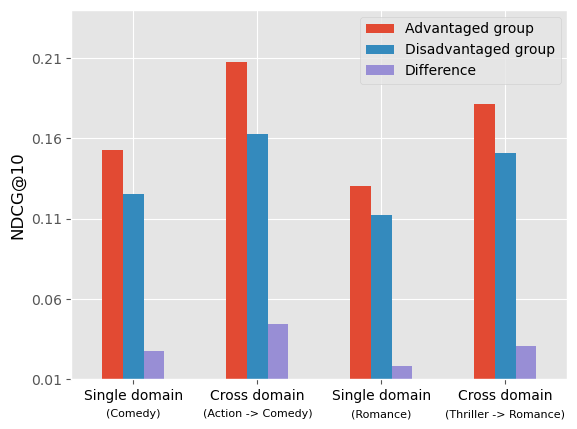

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
data = {
    "Advantaged group":[0.1528, 0.2074,0.1306,0.1814],
    "Disadvantaged group":[0.1251,0.163,0.1123, 0.1507],
    "Difference":[0.0277,0.0444,0.0182,0.0307]
}
df = pd.DataFrame(data,index=["Single domain", "Cross domain","Single domain", "Cross domain"])
# sns.barplot(data=df)
ax = df.plot.bar(rot=0)
# groups = ['Single domain', 'Cross domain']
# subgroups = ['male', 'female', 'difference']

# # Data
# group_data = np.array([[0.1528, 0.1251, 0.0277], [ 0.2074, 0.163, 0.0444]])  # Each inner list is a group

# # Number of groups
# num_groups = len(groups)
# # Number of subgroups per group
# num_subgroups = len(subgroups)

# # Create an array with the positions of the groups
# group_positions = np.arange(num_groups)

# # Width of each bar
# bar_width = 0.2

# # Plotting each subgroup
# for i in range(num_subgroups):
#     plt.bar(group_positions + i * bar_width, group_data[:, i], width=bar_width, label=subgroups[i])
ax.set_yticks(np.arange(0.01, 0.25, 0.05))
# ax.set_title("Source domain: Action,Target domain: Comedy")
ax.text(1, -0.08, '(Action -> Comedy)', ha='center', va='top', fontsize=8, transform=ax.get_xaxis_transform())
ax.text(0, -0.08, f'(Comedy)', ha='center', va='top', fontsize=8, transform=ax.get_xaxis_transform())
ax.text(3, -0.08, '(Thriller -> Romance)', ha='center', va='top', fontsize=8, transform=ax.get_xaxis_transform())
ax.text(2, -0.08, f'(Romance)', ha='center', va='top', fontsize=8, transform=ax.get_xaxis_transform())
ax.set_xticks([0, 1,2,3])
ax.set_xticklabels(["Single domain","Cross domain","Single domain","Cross domain"],fontsize=10,color="black")
ax.set_ylim(0.01,0.24)
ax.set_ylabel("NDCG@10", fontsize=12,color="black")
# ax.legend(fontsize=12)  